Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Starting fast DenseNet121 classification on /content/drive/MyDrive/train...
Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
Training model with 4 classes...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 593s 5s/step - accuracy: 0.4274 - loss: 1.8902 - val_accuracy: 0.5879 - val_loss: 0.8909
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 537s 4s/step - accuracy: 0.6164 - loss: 0.8641 - val_accuracy: 0.6030 - val_loss: 0.8444
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.6563 - loss: 0.7761 - val_accuracy: 0.6108 - val_loss: 0.7875
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.6767 - loss: 0.7354 - val_accuracy: 0.6162 - val_loss: 0.8057
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 514s 4s/step - accuracy: 0.6806 - loss: 0.7123 - val_accuracy: 0.6260 - val_loss: 0.7645
Evaluating model and calculating metrics...
32/32 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step

===== Model Evaluation Metrics =====
Accuracy: 0.6216
Precision: 0.6138
Recall: 0.6216
F1 Score: 0.6131
F2 Score: 0.6170
F0 Score: 0.6138
MCC Score: 0.4998
Kappa Score: 0.4954
Metrics saved to 'densenet121_metrics.csv'


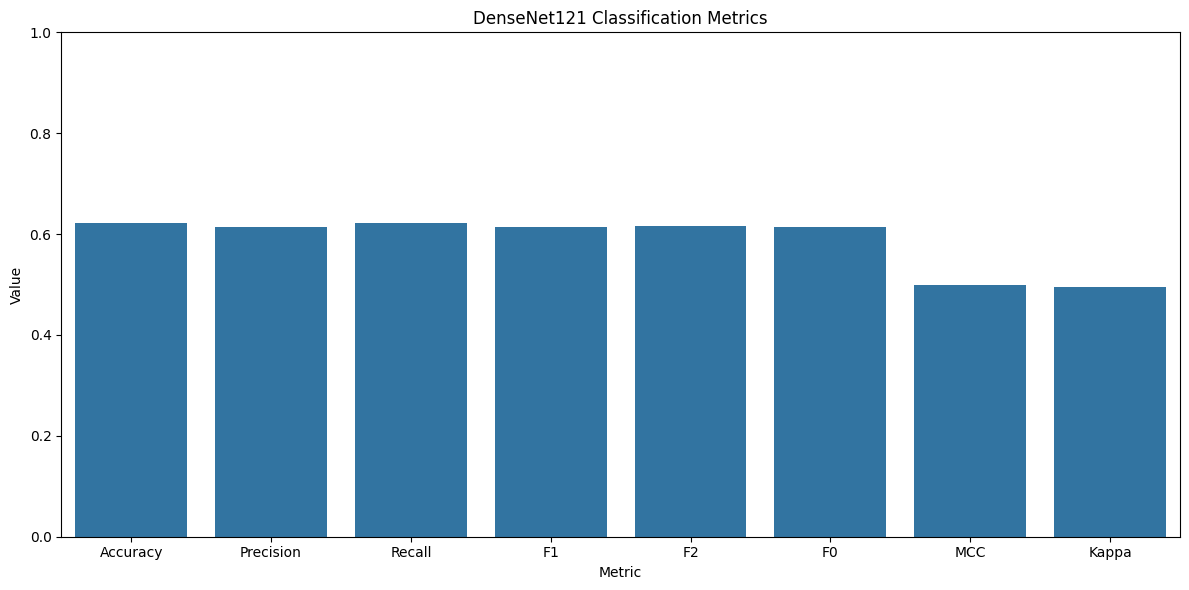

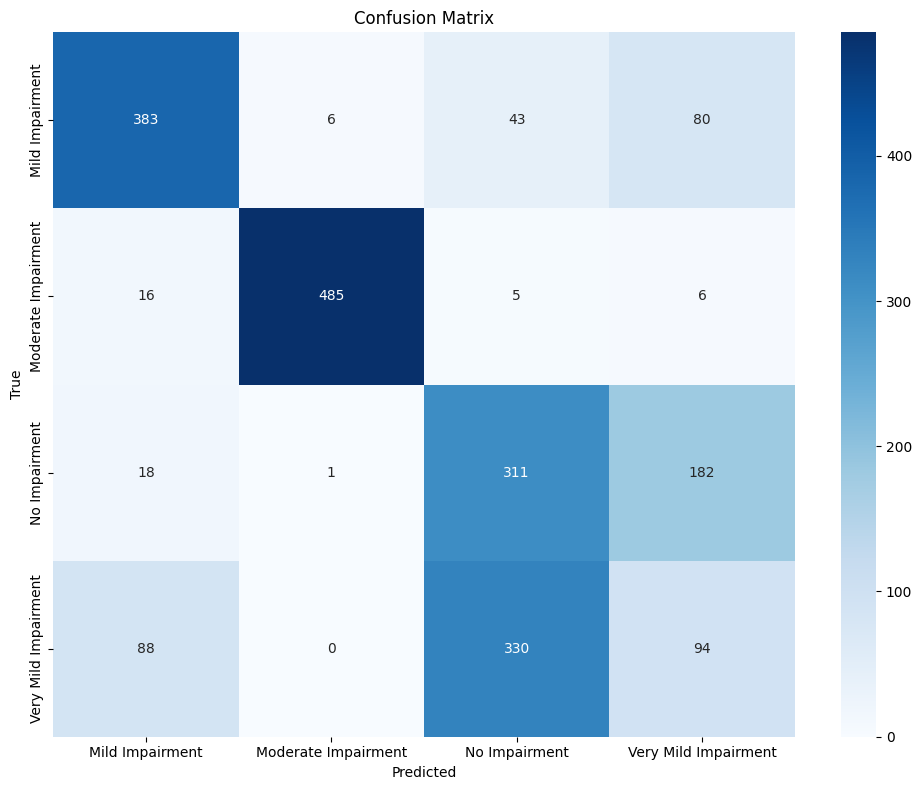

Model saved as 'densenet121_model.h5'


In [7]:
# Hızlandırılmış Image Classification using DenseNet121
# Focusing on quick results with all required metrics

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, matthews_corrcoef,
    cohen_kappa_score, fbeta_score
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
import tensorflow as tf
import random as python_random
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Configuration parameters (optimized for speed)
IMAGE_SIZE = (150, 150)  # Reduced image size for faster processing
BATCH_SIZE = 64  # Larger batch size
EPOCHS = 5  # Fewer epochs
LEARNING_RATE = 0.001  # Higher learning rate
VAL_SPLIT = 0.2  # Validation split

# Define metrics calculation function
def calculate_metrics(y_true, y_pred):
    """Calculate all required metrics"""
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted')

    # F-scores
    metrics['f1'] = f1_score(y_true, y_pred, average='weighted')
    metrics['f2'] = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics['f0'] = fbeta_score(y_true, y_pred, beta=0, average='weighted')

    # Advanced metrics
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    metrics['kappa'] = cohen_kappa_score(y_true, y_pred)

    return metrics

# Simplified model building function
def build_simplified_model(num_classes):
    # Load the DenseNet121 with pre-trained weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )

    # Freeze all base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add simplified classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile with higher learning rate
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Simplified training function
def fast_train(model, train_generator, validation_generator):
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )

    # Train with fewer epochs
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

# Function to evaluate and display all metrics
def evaluate_and_display_metrics(model, test_generator):
    # Get predictions
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes

    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred)

    # Display metrics
    print("\n===== Model Evaluation Metrics =====")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"F2 Score: {metrics['f2']:.4f}")
    print(f"F0 Score: {metrics['f0']:.4f}")
    print(f"MCC Score: {metrics['mcc']:.4f}")
    print(f"Kappa Score: {metrics['kappa']:.4f}")

    # Create dataframe for metrics
    metrics_df = pd.DataFrame({
        'Metric': [
            'Accuracy', 'Precision', 'Recall',
            'F1', 'F2', 'F0',
            'MCC', 'Kappa'
        ],
        'Value': [
            metrics['accuracy'], metrics['precision'], metrics['recall'],
            metrics['f1'], metrics['f2'], metrics['f0'],
            metrics['mcc'], metrics['kappa']
        ]
    })

    # Save metrics to CSV
    metrics_df.to_csv('densenet121_metrics.csv', index=False)
    print("Metrics saved to 'densenet121_metrics.csv'")

    # Plot metrics as bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Value', data=metrics_df)
    plt.title('DenseNet121 Classification Metrics')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('metrics_chart.png')
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=list(test_generator.class_indices.keys()),
        yticklabels=list(test_generator.class_indices.keys())
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return metrics_df

# Main execution function
def run_fast_classification(data_folder):
    print(f"Starting fast DenseNet121 classification on {data_folder}...")

    # Check if data folder exists
    if not os.path.exists(data_folder):
        print(f"Error: Data folder '{data_folder}' not found.")
        return None

    # Create data generators with simpler augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=VAL_SPLIT
    )

    # Check folder structure
    if os.path.exists(os.path.join(data_folder, 'train')):
        # Has train/test structure
        train_folder = os.path.join(data_folder, 'train')
        test_folder = os.path.join(data_folder, 'test') if os.path.exists(os.path.join(data_folder, 'test')) else None
    else:
        # Single folder with class subfolders
        train_folder = data_folder
        test_folder = None

    # Create generators
    train_generator = datagen.flow_from_directory(
        train_folder,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        train_folder,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        subset='validation'
    )

    # For test data
    if test_folder:
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_folder,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )
    else:
        # Use validation data as test data
        test_generator = validation_generator

    # Build model
    num_classes = len(train_generator.class_indices)
    model = build_simplified_model(num_classes)

    # Train model
    print(f"Training model with {num_classes} classes...")
    model, history = fast_train(model, train_generator, validation_generator)

    # Evaluate model and get metrics
    print("Evaluating model and calculating metrics...")
    metrics = evaluate_and_display_metrics(model, test_generator)

    # Save model
    model.save('densenet121_model.h5')
    print("Model saved as 'densenet121_model.h5'")

    return model, metrics

# Execute on Colab
if __name__ == "__main__":
    from google.colab import drive

    # Try to mount Google Drive
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except:
        print("Could not mount Google Drive, will use local folders.")

    # Change this path to your dataset folder
    DATA_FOLDER = "/content/drive/MyDrive/train"  # Update this to your folder path

    # Run the fast classification
    model, metrics = run_fast_classification(DATA_FOLDER)